<a href="https://colab.research.google.com/github/rexbrandy/classify_digits/blob/main/classify_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Feed Forward Network

This is a feed forward network that is trained to identify articles of clothing. It is trained with the fashion MNIST dataset. It is a small network with 3 linear layers with ReLu activation.

### Dataloading

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


def get_dataloaders(batch_size=64, visualize=True):
    train_dataset = datasets.FashionMNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_dataset = datasets.FashionMNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    if visualize:
        visualize_data(train_dataset)

    return train_dataloader, test_dataloader


In [5]:
import matplotlib.pyplot as plt


def visualize_data(training_data):
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(training_data), size=(1,)).item()
        img, label = training_data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()



In [8]:
import torch.nn as nn

class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.flatten = nn.Flatten()

        self.sequential = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.Linear(512, 128),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        output = self.sequential(x)

        return output


In [14]:
def train(model, dataloader, criterion, optimizer, n_epochs=20):
    model.train()

    size = len(dataloader.dataset)
    epoch_loss = []

    for epoch in range(1, n_epochs):
        for batch, (X, y) in enumerate(dataloader):
            # Feed forward - calculate prediction and loss
            pred = model(X)
            loss = criterion(pred, y)

            # Backpropogation - set weights and biases and zero gradients
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss.append(loss.item())

            if batch % 100 == 0:
                test_loss = loss.item()
                current = (batch + 1) * len(X)

                print(f'Epoch {epoch}  Current {current} / {size}  Loss {test_loss}')


def test(model, dataloader, criterion):
    model.eval()

    dataset_suize = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += criterion(pred, y).item

            correct += (pred.argmax(1 == y)).type(torch.float).sum().item()

    print(f'Correct {correct} / {size}  Loss {test_loss}')



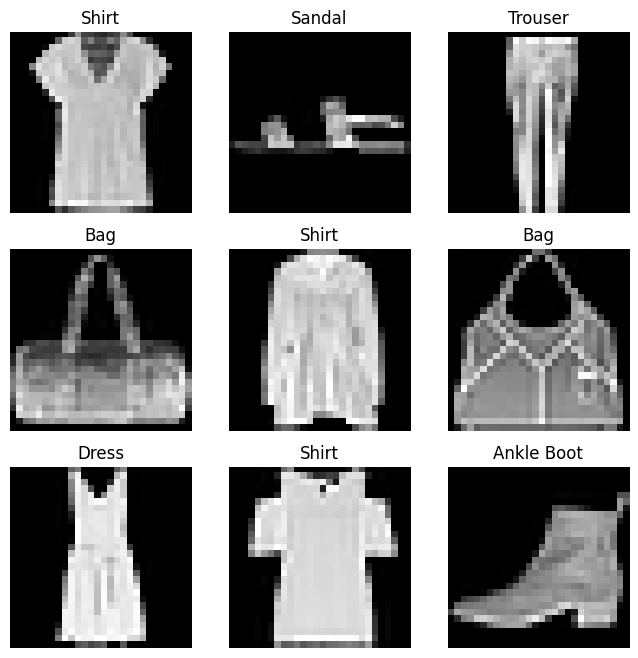

Epoch 1  Current 64 / 60000  Loss 2.3167505264282227
Epoch 1  Current 6464 / 60000  Loss 1.803034782409668
Epoch 1  Current 12864 / 60000  Loss 1.3491581678390503
Epoch 1  Current 19264 / 60000  Loss 1.230495810508728
Epoch 1  Current 25664 / 60000  Loss 0.819320559501648
Epoch 1  Current 32064 / 60000  Loss 1.006289005279541
Epoch 1  Current 38464 / 60000  Loss 0.8446201086044312


In [ ]:
n_epochs = 20
lr = 0.01

model = FeedForwardNet()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=lr)

training_dataloader, test_dataloader = get_dataloaders(visualize=True)

train(model, training_dataloader, criterion, optim, n_epochs)

test(model, test_dataloader, criterion)
